# Effect of the regularization strength

__last update__: 17/08/22

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import os
import copy
import numpy as np
import pickle as pkl
from astropy.io import fits
from scipy.optimize import minimize
import seaborn as sns # for nicer colors on the plot
from collections import OrderedDict

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec, ticker
from matplotlib.colors import Normalize, LogNorm, ListedColormap, TwoSlopeNorm
from matplotlib import patches as mpatches
plt.rc('image', interpolation='none', origin='lower')
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']= r"\usepackage{amsmath}"

from herculens.Util.plot_util import nice_colorbar, nice_colorbar_residuals

In [2]:
SAVE_FIGURES = False
figure_dir = os.path.join('figures', 'regularization strengths')

In [3]:
scale_factor = 3  # potential pixel scale factor

# types of potential perturbations we consider
perturb_types = {
    'dark_halo': "LS", 
    'GRF': "PS", 
    'discyness': "HM"
}
regul_strengths = {
    'low': "low: " + r"$\lambda_{\psi,\rm st}=1$",
    'fiducial': "fiducial: " + r"$\lambda_{\psi,\rm st}=3$",
    'high': "high: " + r"$\lambda_{\psi,\rm st}=5$",
}
#print(regul_strengths, perturb_types)

# for each case, load the saved data from the modeling
all_model_data = {} #OrderedDict()
for perturb_type in perturb_types.keys():
    model_data = {} #OrderedDict()
    for regul_str in regul_strengths.keys():
        with open(os.path.join('results', f'{regul_str}_regul_strength', 
                               f'sumplot-real-{perturb_type}-scale_{scale_factor}-smooth_source-init_from_smooth.pkl'), 'rb') as f:
            content = pkl.load(f)
            model_data[regul_str] = content
    all_model_data[perturb_type] = model_data
    
print(all_model_data.keys())

dict_keys(['dark_halo', 'GRF', 'discyness'])


In [4]:
def get_maps(pertub_type, regul_str):
    data, lens_image, kwargs_result, input_kwargs_result, \
        potential_mask, potential_noise_map, \
        perturb_input, perturb_input_fitgrid, \
        _, cov_matrix_pixpot, _, _, _, _ \
        = all_model_data[pertub_type][regul_str]

    model = lens_image.model(**kwargs_result)
    noise_map = np.sqrt(lens_image.Noise.C_D_model(model))
    res = (model - data) / noise_map
    red_chi2 = np.sum(res**2) / res.size

    # pixelated potential model
    perturb_model = kwargs_result['kwargs_lens'][-1]['pixels']
    return perturb_model, potential_mask, res, red_chi2


def get_mask(pertub_type):
    data, lens_image, kwargs_result, input_kwargs_result, \
        potential_mask, potential_noise_map, \
        perturb_input, perturb_input_fitgrid, \
        _, cov_matrix_pixpot, _, _, _, _ \
        = all_model_data[pertub_type]['fiducial']
    
    extent = lens_image.Grid.extent
    pixel_size = lens_image.Grid.pixel_width
    x_grid, y_grid = lens_image.Grid.pixel_coordinates
    x_grid_fit, y_grid_fit = lens_image.Grid.model_pixel_coordinates('lens')
    
    lensed_src = lens_image.model(**kwargs_result, lens_light_add=False)
    src_snr = lensed_src / np.sqrt(lens_image.Noise.C_D_model(lensed_src))
    src_mask = (src_snr > 5).astype(float)
    bx_grid_fit, by_grid_fit = lens_image.LensModel.ray_shooting(x_grid_fit, y_grid_fit, kwargs_result['kwargs_lens'])
    lensed_src_fitgrid = lens_image.SourceModel.surface_brightness(bx_grid_fit, by_grid_fit, kwargs_result['kwargs_source'])
    lensed_src_fitgrid *= lens_image.Grid.pixel_area
    src_snr_fitgrid = lensed_src_fitgrid / np.sqrt(lens_image.Noise.C_D_model(lensed_src_fitgrid, force_recompute=True))
    src_mask_fitgrid = np.array((src_snr_fitgrid > 5).astype(float))
    src_mask_nans = np.nan*np.zeros_like(src_mask)
    src_mask_nans[src_mask == 0] = 1
    return src_mask_nans, extent, pixel_size

In [5]:
def optimal_offset(model, target, mask=None, noise_map=None):
    """Function to minimize constant offset between two images."""
    if mask is None: mask = np.ones_like(target)
    if noise_map is None: noise_map = np.ones_like(model)
    loss_fun = lambda offset: 0.5 * np.sum(mask*(model+offset - target)**2/noise_map**2)
    init_offset = 0.
    result = minimize(loss_fun, init_offset)
    final_offset = float(result.x[0])
    return final_offset 

def levels_for_source(image, frac_levels=[0.5], n=1000):
    """compute specific levels from an image, based on fraction of the total flux.
    Useful for getting an (approximated) half-light radius from an image.
    Note that 'total light' here is defined as the sum of the `image` pixels.
    """
    from scipy import interpolate
    z = np.array(image)
    t = np.linspace(0.0, z.max(), n)
    integral = ((z >= t[:, None, None]) * z).sum(axis=(1, 2))
    f = interpolate.interp1d(integral, t)
    levels = f(np.array(frac_levels) * z.sum())
    return levels

In [17]:
def set_col_title(ax, title, fontsize=16):
    ax.text(0.5, 1.02, title, transform=ax.transAxes,
            ha='center', va='bottom', fontsize=fontsize)

def set_row_title(ax, title, fontsize=16):
    ax.text(-0.3, 0.5, title, transform=ax.transAxes, rotation=90,
            ha='left', va='center', fontsize=fontsize)
    
def add_scale_bar(ax, extent, pixel_size, size_arcsec=1, bar_width_pixel=1, 
                  position=None, color='white', fontsize=16):
    if position is None:
        position = (extent[0]+5*pixel_size, extent[2]+5*pixel_size)
    width, height = size_arcsec, bar_width_pixel*pixel_size
    bar = mpatches.Rectangle(position, width, height, facecolor=color)
    ax.add_patch(bar)
    text_offset_y = 2 * height
    text = '{}"'.format(size_arcsec)
    ax.text(position[0]+width/2., position[1]+text_offset_y, text, color=color, fontsize=fontsize, 
            horizontalalignment='center', verticalalignment='bottom')

def add_text_box(ax, text, loc='right', fontsize=16,
                 txt_color='black', txt_alpha=1,
                 bg_color='white', bg_alpha=1):
    if loc == 'right':
        x, y = 0.95, 0.05
        ha, va = 'right', 'bottom'
    elif loc == 'left':
        x, y = 0.05, 0.05
        ha, va = 'left', 'bottom'
    elif loc == 'top left':
        x, y = 0.05, 0.95
        ha, va = 'left', 'top'
    elif loc == 'top right':
        x, y = 0.95, 0.95
        ha, va = 'right', 'top'
    ax.text(x, y, text, color=txt_color, alpha=txt_alpha, fontsize=fontsize, 
            horizontalalignment=ha, verticalalignment=va,
            transform=ax.transAxes, bbox={'color': bg_color, 'alpha': bg_alpha})

=== DARK_HALO (lens LS) ===
potential model offset = 0.031
potential model offset = 0.027
potential model offset = 0.024
=== GRF (lens PS) ===
potential model offset = 0.000
potential model offset = 0.000
potential model offset = 0.000
=== DISCYNESS (lens HM) ===
potential model offset = 0.000
potential model offset = 0.000
potential model offset = 0.000


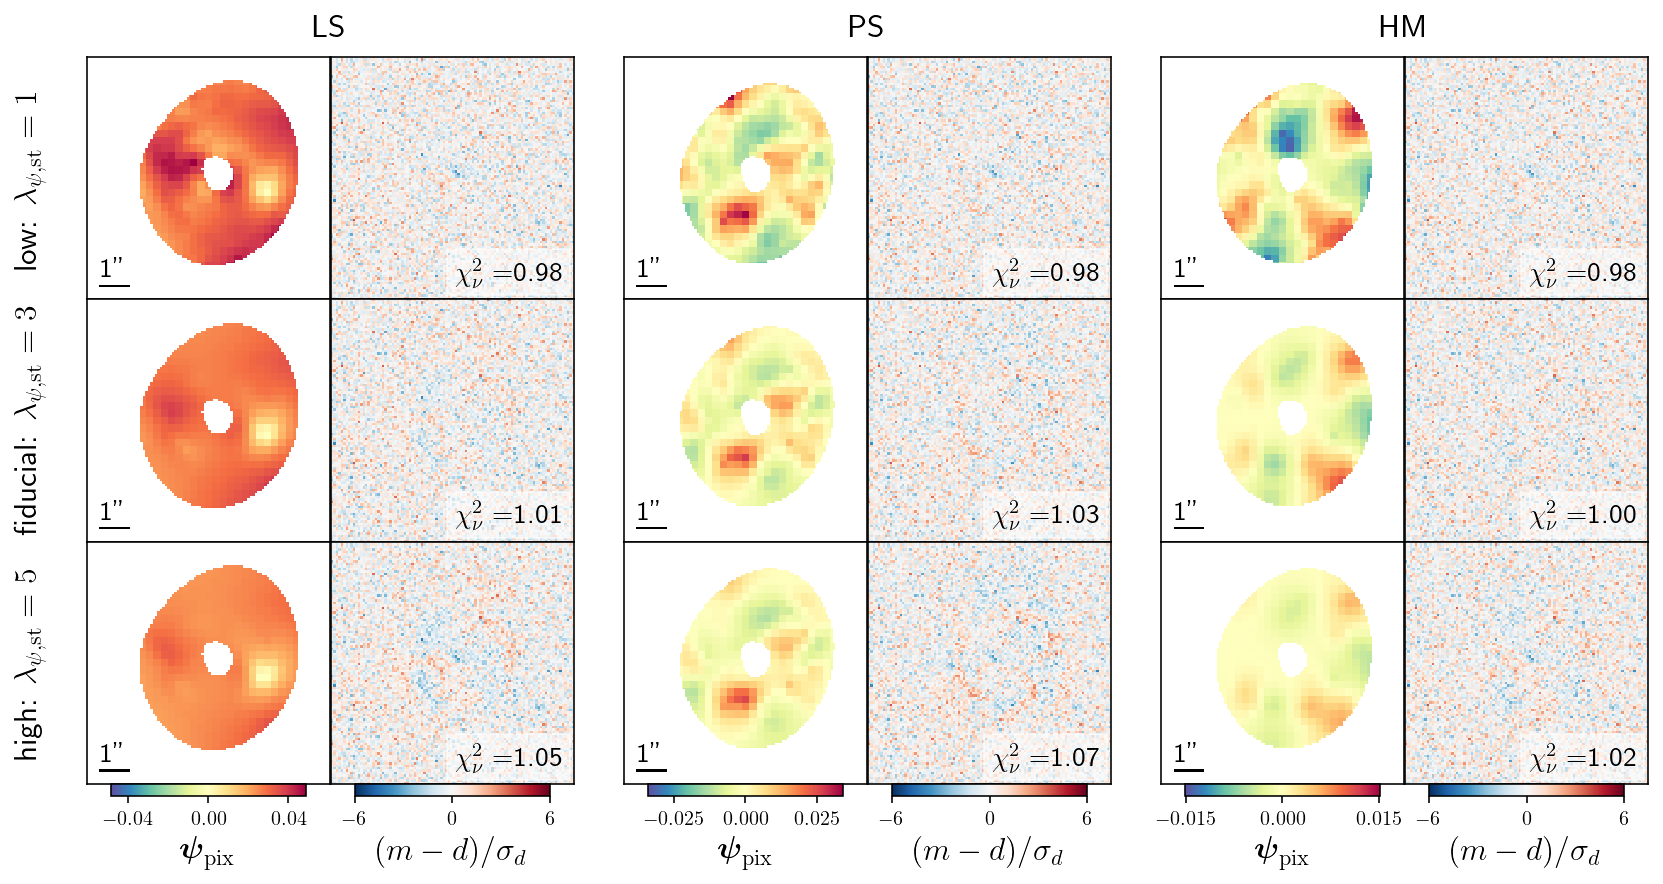

In [18]:
source_zoom_in = True
shared_pixpot_norms = False
mask_opacity, cont_opacity = 1, 0

trunc_fractor = 0.8  # only for dark halo

fontsize = 14
fontsize_col = 16
fontsize_row = 16
fontsize_cb = 16
cb_pad = 0.1

norm_res = Normalize(-6, 6)

cmap_res = plt.get_cmap('RdBu_r')
cmap_pot = copy.copy(plt.get_cmap('Spectral_r'))
cmap_pot_cut = ListedColormap(cmap_pot(np.linspace(0.5, 1, 128)))

figsize = (14, 6.8)
fig = plt.figure(figsize=figsize)
gs  = gridspec.GridSpec(1, len(perturb_types), 
                        hspace=0, wspace=0.1)
    
for i, (perturb_type, perturb_name) in enumerate(perturb_types.items()):
    first_col = (i == 0)
    
    print(f"=== {perturb_type.upper()} (lens {perturb_name}) ===")
    
    # add title
    ax = fig.add_subplot(gs[i])
    set_col_title(ax, perturb_name, fontsize=fontsize_col)
    ax.axis('off')
    
    # create group of subplots
    gs_sub = gridspec.GridSpecFromSubplotSpec(4, 2, subplot_spec=gs[i], 
                                              height_ratios=(1, 1, 1, 0.05),
                                              hspace=0, wspace=0)
    
    # get the source mask
    src_mask, extent, pixel_size = get_mask(perturb_type)
    
    for j, (regul_str, regul_label) in enumerate(regul_strengths.items()):
        first_row = (j == 0)
        last_row  = (j == len(regul_strengths)-1)
    
        # load all necessary data
        pixpot_model, pixpot_mask, norm_residuals, red_chi2 = get_maps(perturb_type, regul_str)
        
        # compute colorcuts and normalizations
        if 'dark_halo' in perturb_type:
            offset_model = - pixpot_model[pixpot_mask == 1].min() # + perturb_input_fitgrid.min()
        else:
            offset_model = 0.
        print(f"potential model offset = {offset_model:.3f}")
        pixpot_model_o = (pixpot_model + offset_model)
        
        # the colorcut is based on the 'low regularization' results:
        if 'low' in regul_str:
            vmax = np.abs(pixpot_model_o[pixpot_mask==1]).max()
            norm_pot = Normalize(-vmax, vmax)

        ##### Panel 1: pixelated potential model #####
        ax = fig.add_subplot(gs_sub[j, 0])
        if first_col: set_row_title(ax, regul_label, fontsize=fontsize_row)
        im = ax.imshow(pixpot_model_o, extent=extent, cmap=cmap_pot, norm=norm_pot)
        im.set_rasterized(True)
        ax.imshow(src_mask, extent=extent, cmap='gray_r')
        add_scale_bar(ax, extent, pixel_size, size_arcsec=1,
                      color='black', fontsize=fontsize)
        ax.set_xticks([]); ax.set_yticks([])
        if last_row:
            # here we make some custom space for the colorspace
            gs_cb = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_sub[j+1, 0], 
                                                     width_ratios=(0.1, 0.8, 0.1),
                                                     hspace=0, wspace=0)
            ax = fig.add_subplot(gs_cb[1])
            cb = plt.colorbar(im, cax=ax, orientation='horizontal', shrink=0.5) #,ticks=[norm_pot.vmin, 0, norm_pot.vmax])
            cb.set_label(r"$\boldsymbol{\psi}_{\rm pix}$", fontsize=fontsize_cb)
            tick_locator = ticker.MaxNLocator(nbins=3)
            cb.locator = tick_locator
            cb.update_ticks()
        
        
        ##### Panel 2: normalized residuals #####
        ax = fig.add_subplot(gs_sub[j, 1])
        im = ax.imshow(norm_residuals, extent=extent, cmap=cmap_res, norm=norm_res)
        im.set_rasterized(True)
        add_text_box(ax, r"$\chi^2_\nu=$"+f"{red_chi2:.2f}", 
                     fontsize=fontsize, txt_color='black', bg_color='white', bg_alpha=0.5)
        ax.set_xticks([]); ax.set_yticks([])
        if last_row:
            gs_cb = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs_sub[j+1, 1], 
                                                     width_ratios=(0.1, 0.8, 0.1),
                                                     hspace=0, wspace=0)
            ax = fig.add_subplot(gs_cb[1])
            cb = plt.colorbar(im, cax=ax, orientation='horizontal', shrink=0.5,
                              ticks=[norm_res.vmin, 0, norm_res.vmax])
            cb.set_label(r"$(m - d)/\sigma_d$", fontsize=fontsize_cb)
    
    
#fig.subplots_adjust(hspace=0.1, wspace=0)
#fig.tight_layout()
plt.show()


In [20]:
if SAVE_FIGURES:
    # saving as pdf causes weird misalignments of axes, so I save in jpg
    figure_name = f'effect_regul_strength-wavelet_pot_{scale_factor}-smooth_src-full.pdf'
    fig.savefig(os.path.join(figure_dir, figure_name), bbox_inches='tight', dpi=300)